### State networks already spending enough using leaders pricing

Why:
- Evan's story for state networks is that they just need to ensure their upstream circuits are either 1G or 10G, and prices are better than ever!

What:
- Evan wants to know if we can make the argument that is what state leaders are paying, and can we show that state networks states are already spending that?

- he originally asked, where the various state networks would be on % of districts meeting 1 mbps if they all had the price of the leaders? but i followed up with this offering, which i think he will be happy with.

How:
- first review surafaels leader $ figures: https://docs.google.com/document/d/1lHY-sejLfTA8eDQIdh8SAvw-Tn96FeRhOqZhZKRwCok/edit

- first calculate, for all state network states, how much would it cost to get the state to get 1Mbps/student for all their districts at these prices?

- then calculate, for all districts in state network states, how much is being spent on IA for all districts in the state? this may not be 100% clean, so extrapolation will be necessary.

- then calculate, how many states are already spending enough according to these benchmarks?

In [1]:
import math
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# get states that are in state network
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [3]:
#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

### QA Task 1

In [4]:
# sql_query_part1
sql_query = """
select 
  d.district_id, 
  d.funding_year, 
  d.name, 
  d.state_code, 
  d.num_students, 
  dbw.ia_bw_mbps_total, 
  dbw.ia_monthly_cost_total, 
  dbw.projected_bw_fy2018, 
  dbw.meeting_2018_goal_oversub, 
  dffa.fit_for_ia, 
  dffa.fit_for_ia_cost, 
  ss.sea_name, 
  ss.name as ss_name, 
  ss.state_network 
from 
  ps.districts d 
  JOIN ps.districts_bw_cost dbw on d.funding_year = dbw.funding_year 
  and d.district_id = dbw.district_id 
  join ps.districts_fit_for_analysis dffa ON d.funding_year = dffa.funding_year 
  and d.district_id = dffa.district_id 
  join ps.states_static ss on d.state_code = ss.name 
where 
  d.funding_year = 2019 
  and d.in_universe = true 
  and d.district_type = 'Traditional' 
  and ss.state_network = true
"""

#pull bandwidths from DB
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

### Convert decimal to numeric

In [5]:
# convert from decimal to numeric
numeric_cols = ['ia_monthly_cost_total', 'projected_bw_fy2018']
df[numeric_cols] = df[numeric_cols].astype(float)

### 1Mbps Leaders: $1.31

### Masks/Filters

In [6]:
mask_fit = df.fit_for_ia == True
mask_fit_cost = df.fit_for_ia_cost == True

In [7]:
# define aggregations
agg_dict = {'district_id': 'count', 'num_students': 'sum'}

# groupby state and aggregate
df_all = df.groupby('state_code').agg(agg_dict)
df_clean = df[mask_fit & mask_fit_cost].groupby('state_code').agg(agg_dict)
df_clean.columns = ['district_count_clean', 'num_students_clean']

### Cost extrapolation

In [8]:
# population
num_population_cost = df.groupby('state_code')['ia_monthly_cost_total'].sum()
num_population_cost

state_code
AL    9.802163e+05
AR    1.304327e+06
CT    2.514289e+05
DE    1.530685e+05
GA    8.564906e+05
HI    3.539232e+05
IA    6.172934e+05
KY    9.351807e+05
ME    1.718579e+05
MO    9.116595e+05
MS    3.399010e+05
NC    1.183498e+06
ND    2.135594e+05
NE    3.735481e+05
RI    2.360433e+05
SC    4.031323e+05
SD    2.659863e+05
UT    5.317535e+05
WA    7.129415e+05
WI    8.598031e+05
WV    4.256631e+05
WY    1.341431e+05
Name: ia_monthly_cost_total, dtype: float64

In [9]:
# sample
num_sample_cost = df[mask_fit & mask_fit_cost].groupby('state_code')['ia_monthly_cost_total'].agg([('ia_monthly_cost_total_clean','sum')])
num_sample_cost

,ia_monthly_cost_total_clean
state_code,
AL,9.802163e+05
AR,1.293762e+06
CT,2.421289e+05
DE,1.530685e+05
GA,8.564906e+05
HI,3.539232e+05
IA,6.126286e+05
KY,9.351807e+05
ME,1.625773e+05


### Projected bw to Meet 1 Mbps oversub

In [10]:
total_projected_bw_fy2018 = df[['state_code','projected_bw_fy2018']].groupby('state_code')['projected_bw_fy2018'].agg([('total_projected_bw_fy2018', 'sum')])

total_projected_bw_fy2018_clean = df[mask_fit & mask_fit_cost][['state_code','projected_bw_fy2018']].groupby('state_code')['projected_bw_fy2018'].agg([('total_projected_bw_fy2018_clean', 'sum')])



### IA Costs

In [11]:
# district_count_clean, num_students_clean, ia_monthly_cost_total_clean: fit_for_ia and fit_for_ia_cost are True
# merging dfs
df_results = pd.concat([df_all, df_clean, 
                        total_projected_bw_fy2018, total_projected_bw_fy2018_clean,
                        num_population_cost, num_sample_cost], axis=1)
df_results

,district_id,num_students,district_count_clean,num_students_clean,total_projected_bw_fy2018,total_projected_bw_fy2018_clean,ia_monthly_cost_total,ia_monthly_cost_total_clean
state_code,,,,,,,,
AL,135,735819,134,733545,585391.50,583117.50,9.802163e+05,9.802163e+05
AR,234,473462,228,468009,416296.10,410939.70,1.304327e+06,1.293762e+06
CT,162,486495,157,471951,414914.25,402460.05,2.514289e+05,2.421289e+05
DE,17,112978,17,112978,93042.55,93042.55,1.530685e+05,1.530685e+05
GA,180,1714011,179,1713710,1310520.45,1310219.45,8.564906e+05,8.564906e+05
HI,1,171502,1,171502,120051.40,120051.40,3.539232e+05,3.539232e+05
IA,330,496888,305,482661,439086.25,424968.00,6.172934e+05,6.126286e+05
KY,173,673469,173,673469,550874.60,550874.60,9.351807e+05,9.351807e+05
ME,183,173580,166,163871,160165.80,151146.05,1.718579e+05,1.625773e+05


### QA Task 2

### Projected costs

In [12]:
# leader_price (subject to change)
leader_price = 1.31

# projected cost, clean, oversub
df_results['cost_leader_pricing_oversub_clean'] = df_results['total_projected_bw_fy2018_clean']*leader_price

# projected cost, clean, no oversub
df_results['cost_leader_pricing_no_oversub_clean'] = df_results['num_students_clean']*leader_price

# projected cost, not clean, oversub
df_results['cost_leader_pricing_oversub'] = df_results['total_projected_bw_fy2018']*leader_price

# projected cost, not clean, no oversub
df_results['cost_leader_pricing_no_oversub'] = df_results['num_students']*leader_price

In [13]:
df_results

,district_id,num_students,district_count_clean,num_students_clean,total_projected_bw_fy2018,total_projected_bw_fy2018_clean,ia_monthly_cost_total,ia_monthly_cost_total_clean,cost_leader_pricing_oversub_clean,cost_leader_pricing_no_oversub_clean,cost_leader_pricing_oversub,cost_leader_pricing_no_oversub
state_code,,,,,,,,,,,,
AL,135,735819,134,733545,585391.50,583117.50,9.802163e+05,9.802163e+05,7.638839e+05,960943.95,7.668629e+05,963922.89
AR,234,473462,228,468009,416296.10,410939.70,1.304327e+06,1.293762e+06,5.383310e+05,613091.79,5.453479e+05,620235.22
CT,162,486495,157,471951,414914.25,402460.05,2.514289e+05,2.421289e+05,5.272227e+05,618255.81,5.435377e+05,637308.45
DE,17,112978,17,112978,93042.55,93042.55,1.530685e+05,1.530685e+05,1.218857e+05,148001.18,1.218857e+05,148001.18
GA,180,1714011,179,1713710,1310520.45,1310219.45,8.564906e+05,8.564906e+05,1.716387e+06,2244960.10,1.716782e+06,2245354.41
HI,1,171502,1,171502,120051.40,120051.40,3.539232e+05,3.539232e+05,1.572673e+05,224667.62,1.572673e+05,224667.62
IA,330,496888,305,482661,439086.25,424968.00,6.172934e+05,6.126286e+05,5.567081e+05,632285.91,5.752030e+05,650923.28
KY,173,673469,173,673469,550874.60,550874.60,9.351807e+05,9.351807e+05,7.216457e+05,882244.39,7.216457e+05,882244.39
ME,183,173580,166,163871,160165.80,151146.05,1.718579e+05,1.625773e+05,1.980013e+05,214671.01,2.098172e+05,227389.80


### Add Pretty Print for plotting

In [14]:
# format thousands as string
cols_to_pp = ['ia_monthly_cost_total',
       'ia_monthly_cost_total_clean', 'cost_leader_pricing_oversub_clean',
       'cost_leader_pricing_no_oversub_clean', 'cost_leader_pricing_oversub',
       'cost_leader_pricing_no_oversub']

def format_k_MM(row):
    if row >= 1000000:
        row_to_format = row/1000000
        return '{:,.1f}M'.format(row_to_format)
    else:
        row_to_format = row/1000
        return '{:,.0f}k'.format(row_to_format)

for col in cols_to_pp:
    df_results[col+'_pp'] = df_results[col].apply(format_k_MM)

In [15]:
df_results

,district_id,num_students,district_count_clean,num_students_clean,total_projected_bw_fy2018,total_projected_bw_fy2018_clean,ia_monthly_cost_total,ia_monthly_cost_total_clean,cost_leader_pricing_oversub_clean,cost_leader_pricing_no_oversub_clean,cost_leader_pricing_oversub,cost_leader_pricing_no_oversub,ia_monthly_cost_total_pp,ia_monthly_cost_total_clean_pp,cost_leader_pricing_oversub_clean_pp,cost_leader_pricing_no_oversub_clean_pp,cost_leader_pricing_oversub_pp,cost_leader_pricing_no_oversub_pp
state_code,,,,,,,,,,,,,,,,,,
AL,135,735819,134,733545,585391.50,583117.50,9.802163e+05,9.802163e+05,7.638839e+05,960943.95,7.668629e+05,963922.89,980k,980k,764k,961k,767k,964k
AR,234,473462,228,468009,416296.10,410939.70,1.304327e+06,1.293762e+06,5.383310e+05,613091.79,5.453479e+05,620235.22,1.3M,1.3M,538k,613k,545k,620k
CT,162,486495,157,471951,414914.25,402460.05,2.514289e+05,2.421289e+05,5.272227e+05,618255.81,5.435377e+05,637308.45,251k,242k,527k,618k,544k,637k
DE,17,112978,17,112978,93042.55,93042.55,1.530685e+05,1.530685e+05,1.218857e+05,148001.18,1.218857e+05,148001.18,153k,153k,122k,148k,122k,148k
GA,180,1714011,179,1713710,1310520.45,1310219.45,8.564906e+05,8.564906e+05,1.716387e+06,2244960.10,1.716782e+06,2245354.41,856k,856k,1.7M,2.2M,1.7M,2.2M
HI,1,171502,1,171502,120051.40,120051.40,3.539232e+05,3.539232e+05,1.572673e+05,224667.62,1.572673e+05,224667.62,354k,354k,157k,225k,157k,225k
IA,330,496888,305,482661,439086.25,424968.00,6.172934e+05,6.126286e+05,5.567081e+05,632285.91,5.752030e+05,650923.28,617k,613k,557k,632k,575k,651k
KY,173,673469,173,673469,550874.60,550874.60,9.351807e+05,9.351807e+05,7.216457e+05,882244.39,7.216457e+05,882244.39,935k,935k,722k,882k,722k,882k
ME,183,173580,166,163871,160165.80,151146.05,1.718579e+05,1.625773e+05,1.980013e+05,214671.01,2.098172e+05,227389.80,172k,163k,198k,215k,210k,227k


### QA Task 3

### Adding already spending column

In [16]:
# clean, oversub
df_results['already_spending_clean_oversub'] = df_results['ia_monthly_cost_total_clean'] >= df_results['cost_leader_pricing_oversub_clean']

# clean, no oversub
df_results['already_spending_clean_no_oversub'] = df_results['ia_monthly_cost_total_clean'] >= df_results['cost_leader_pricing_no_oversub_clean']

# not clean, oversub
df_results['already_spending_oversub'] = df_results['ia_monthly_cost_total'] >= df_results['cost_leader_pricing_oversub']

# not clean, no oversub
df_results['already_spending_no_oversub'] = df_results['ia_monthly_cost_total'] >= df_results['cost_leader_pricing_no_oversub']


In [17]:
df_results

,district_id,num_students,district_count_clean,num_students_clean,total_projected_bw_fy2018,total_projected_bw_fy2018_clean,ia_monthly_cost_total,ia_monthly_cost_total_clean,cost_leader_pricing_oversub_clean,cost_leader_pricing_no_oversub_clean,...,ia_monthly_cost_total_pp,ia_monthly_cost_total_clean_pp,cost_leader_pricing_oversub_clean_pp,cost_leader_pricing_no_oversub_clean_pp,cost_leader_pricing_oversub_pp,cost_leader_pricing_no_oversub_pp,already_spending_clean_oversub,already_spending_clean_no_oversub,already_spending_oversub,already_spending_no_oversub
state_code,,,,,,,,,,,,,,,,,,,,,
AL,135,735819,134,733545,585391.50,583117.50,9.802163e+05,9.802163e+05,7.638839e+05,960943.95,...,980k,980k,764k,961k,767k,964k,True,True,True,True
AR,234,473462,228,468009,416296.10,410939.70,1.304327e+06,1.293762e+06,5.383310e+05,613091.79,...,1.3M,1.3M,538k,613k,545k,620k,True,True,True,True
CT,162,486495,157,471951,414914.25,402460.05,2.514289e+05,2.421289e+05,5.272227e+05,618255.81,...,251k,242k,527k,618k,544k,637k,False,False,False,False
DE,17,112978,17,112978,93042.55,93042.55,1.530685e+05,1.530685e+05,1.218857e+05,148001.18,...,153k,153k,122k,148k,122k,148k,True,True,True,True
GA,180,1714011,179,1713710,1310520.45,1310219.45,8.564906e+05,8.564906e+05,1.716387e+06,2244960.10,...,856k,856k,1.7M,2.2M,1.7M,2.2M,False,False,False,False
HI,1,171502,1,171502,120051.40,120051.40,3.539232e+05,3.539232e+05,1.572673e+05,224667.62,...,354k,354k,157k,225k,157k,225k,True,True,True,True
IA,330,496888,305,482661,439086.25,424968.00,6.172934e+05,6.126286e+05,5.567081e+05,632285.91,...,617k,613k,557k,632k,575k,651k,True,False,True,False
KY,173,673469,173,673469,550874.60,550874.60,9.351807e+05,9.351807e+05,7.216457e+05,882244.39,...,935k,935k,722k,882k,722k,882k,True,True,True,True
ME,183,173580,166,163871,160165.80,151146.05,1.718579e+05,1.625773e+05,1.980013e+05,214671.01,...,172k,163k,198k,215k,210k,227k,False,False,False,False


### QA Task 4

### Plots

### Plot 1: Sorted, Clean, oversub

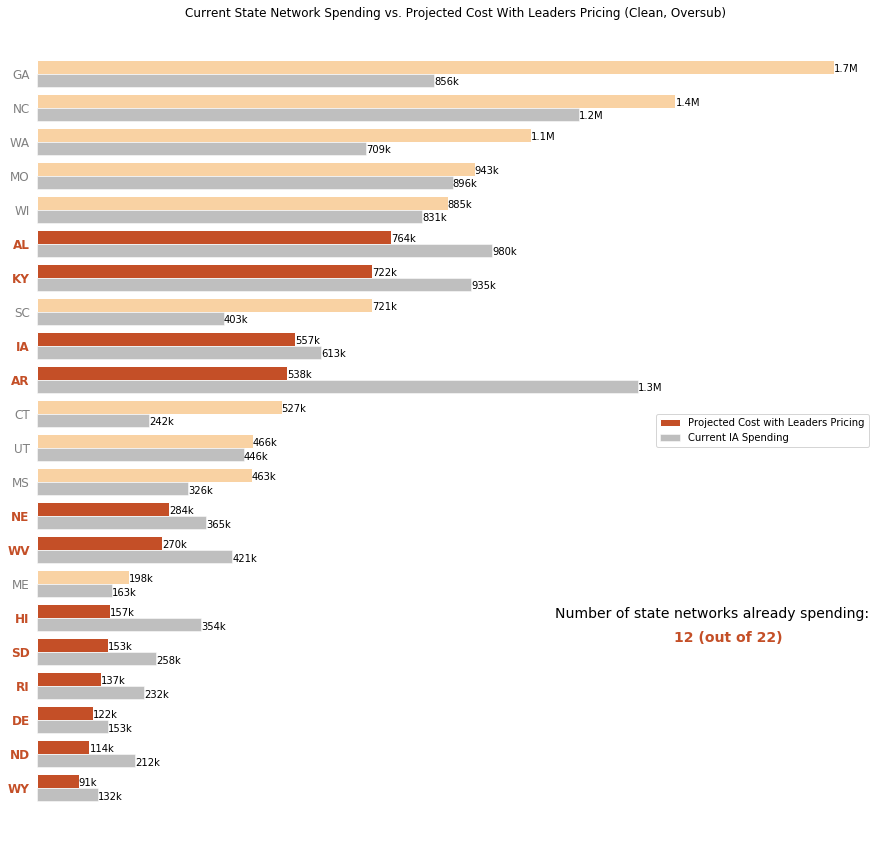

In [34]:
sort_col = 'cost_leader_pricing_oversub_clean'
compare_col = 'ia_monthly_cost_total_clean'
already_spending_col = 'already_spending_clean_oversub'
df_input = df_results.sort_values(sort_col)

# customize colors
colors = []
for proj_cost, orig_cost in zip(df_input[sort_col], df_input[compare_col]): # keys are the names of the boys
    if orig_cost >= proj_cost:
        colors.append('#c44f27')
    else:
        colors.append('#f9d2a3')

fig, ax = plt.subplots(figsize=(15, 15))

bar_size = 0.4

y_locs = np.arange(df_results.shape[0])

rects1 = ax.barh(y_locs, df_input[sort_col], align='edge', edgecolor='white', height=bar_size, color=colors, label="Projected Cost with Leaders Pricing")
rects2 = ax.barh(y_locs - bar_size, df_input.ia_monthly_cost_total_clean, edgecolor='white', align='edge', height=bar_size, color='grey', label="Current IA Spending", alpha=0.5)

# pretty plot
plt.yticks(y_locs, df_input.index);
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), colors):
    ticklabel.set_color('grey')
    ticklabel.set_fontsize(12) 
    if tickcolor == '#c44f27':
        ticklabel.set_color(tickcolor)
        ticklabel.set_fontweight('bold')

plt.title("Current State Network Spending vs. Projected Cost With Leaders Pricing (Clean, Oversub)")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
plt.box(None)
plt.legend(loc='center right');

# add labels
for y0, y1, v0, v1, label_proj, label_sn in zip(y_locs, y_locs - bar_size, 
                                            df_input[sort_col], df_input[compare_col],  
                                                df_input[sort_col+'_pp'], df_input[compare_col+'_pp']):
    plt.text(v0, y0, label_proj, ha='left', va='bottom')
    plt.text(v1, y1, label_sn, ha='left', va='bottom')
    

# add conclusion
plt.text(0.65*max(df_input[sort_col]), 5, 
         'Number of state networks already spending: ', fontsize=14);

plt.text(0.80*max(df_input[sort_col]), 4.3, 
         str(df_input[already_spending_col].sum()) \
         + " (out of " + str(df_input.shape[0]) + ")", fontsize=14, color='#c44f27', fontweight='bold');


### Plot 2: Sorted, Clean, No Oversub

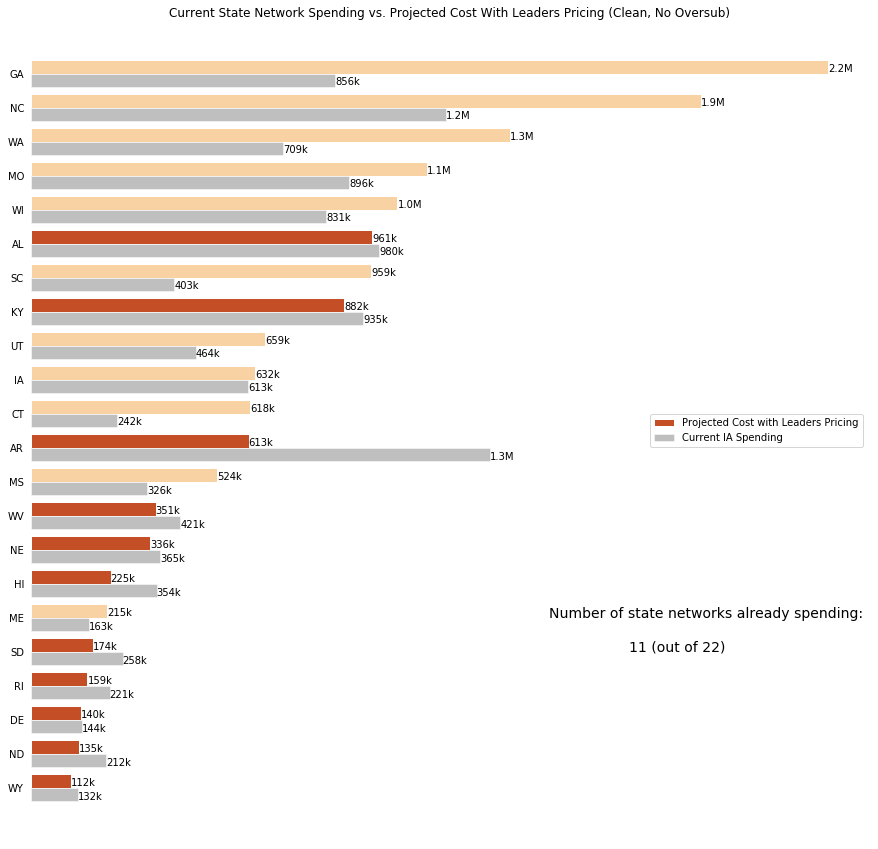

In [143]:
# inputs
sort_col = 'cost_leader_pricing_no_oversub_clean'
compare_col = 'ia_monthly_cost_total_clean'
already_spending_col = 'already_spending_clean_no_oversub'
df_input = df_results.sort_values(sort_col)

# customize colors
colors = []
for proj_cost, orig_cost in zip(df_input[sort_col], df_input[compare_col]): # keys are the names of the boys
    if orig_cost >= proj_cost:
        colors.append('#c44f27')
    else:
        colors.append('#f9d2a3')

fig, ax = plt.subplots(figsize=(15, 15))

bar_size = 0.4

y_locs = np.arange(df_results.shape[0])

rects1 = ax.barh(y_locs, df_input[sort_col], align='edge', edgecolor='white', height=bar_size, color=colors, label="Projected Cost with Leaders Pricing")
rects2 = ax.barh(y_locs - bar_size, df_input[compare_col], edgecolor='white', align='edge', height=bar_size, color='grey', label="Current IA Spending", alpha=0.5)

# pretty plot
plt.yticks(y_locs, df_input.index);
plt.title("Current State Network Spending vs. Projected Cost With Leaders Pricing (Clean, No Oversub)")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
plt.box(None)
plt.legend(loc='center right');

# add labels
for y0, y1, v0, v1, label_proj, label_sn in zip(y_locs, y_locs - bar_size, 
                                            df_input[sort_col], df_input[compare_col],  
                                                df_input[sort_col+'_pp'], df_input[compare_col+'_pp']):
    plt.text(v0, y0, label_proj, ha='left', va='bottom')
    plt.text(v1, y1, label_sn, ha='left', va='bottom')
    

# add conclusion
plt.text(0.65*max(df_input[sort_col]), 5, 
         'Number of state networks already spending: ', fontsize=14);

plt.text(0.75*max(df_input[sort_col]), 4, 
         str(df_input[already_spending_col].sum()) \
         + " (out of " + str(df_input.shape[0]) + ")", fontsize=14);



### Plot 3: Sorted, Not Clean, Oversub

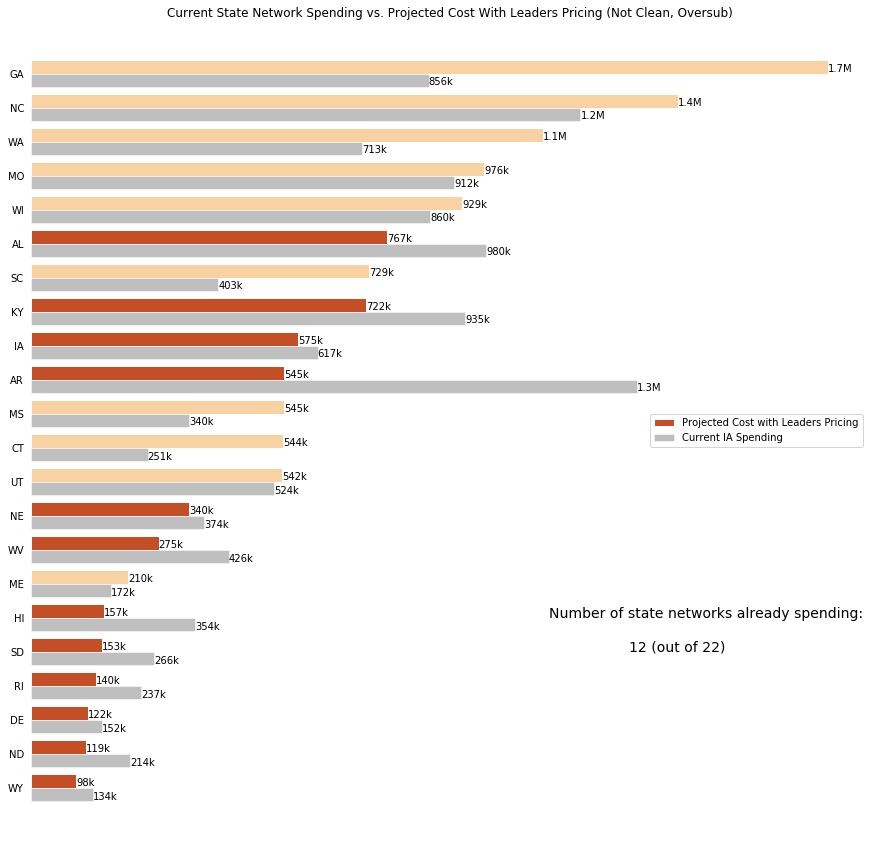

In [142]:
sort_col = 'cost_leader_pricing_oversub'
compare_col = 'ia_monthly_cost_total'
df_input = df_results.sort_values(sort_col)

# customize colors
colors = []
for proj_cost, orig_cost in zip(df_input[sort_col], df_input[compare_col]): # keys are the names of the boys
    if orig_cost >= proj_cost:
        colors.append('#c44f27')
    else:
        colors.append('#f9d2a3')

fig, ax = plt.subplots(figsize=(15, 15))

bar_size = 0.4

y_locs = np.arange(df_results.shape[0])

rects1 = ax.barh(y_locs, df_input[sort_col], align='edge', edgecolor='white', height=bar_size, color=colors, label="Projected Cost with Leaders Pricing")
rects2 = ax.barh(y_locs - bar_size, df_input[compare_col], edgecolor='white', align='edge', height=bar_size, color='grey', label="Current IA Spending", alpha=0.5)

# pretty plot
plt.yticks(y_locs, df_input.index);
plt.title("Current State Network Spending vs. Projected Cost With Leaders Pricing (Not Clean, Oversub)")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
plt.box(None)
plt.legend(loc='center right');

# add labels
for y0, y1, v0, v1, label_proj, label_sn in zip(y_locs, y_locs - bar_size, 
                                            df_input[sort_col], df_input[compare_col],  
                                                df_input[sort_col+'_pp'], df_input[compare_col+'_pp']):
    plt.text(v0, y0, label_proj, ha='left', va='bottom')
    plt.text(v1, y1, label_sn, ha='left', va='bottom')
    

# add conclusion
plt.text(0.65*max(df_input[sort_col]), 5, 
         'Number of state networks already spending: ', fontsize=14);

plt.text(0.75*max(df_input[sort_col]), 4, 
         str(df_input['already_spending_oversub'].sum()) \
         + " (out of " + str(df_input.shape[0]) + ")", fontsize=14);



### Plot 4: Sorted, Not Clean, No Oversub

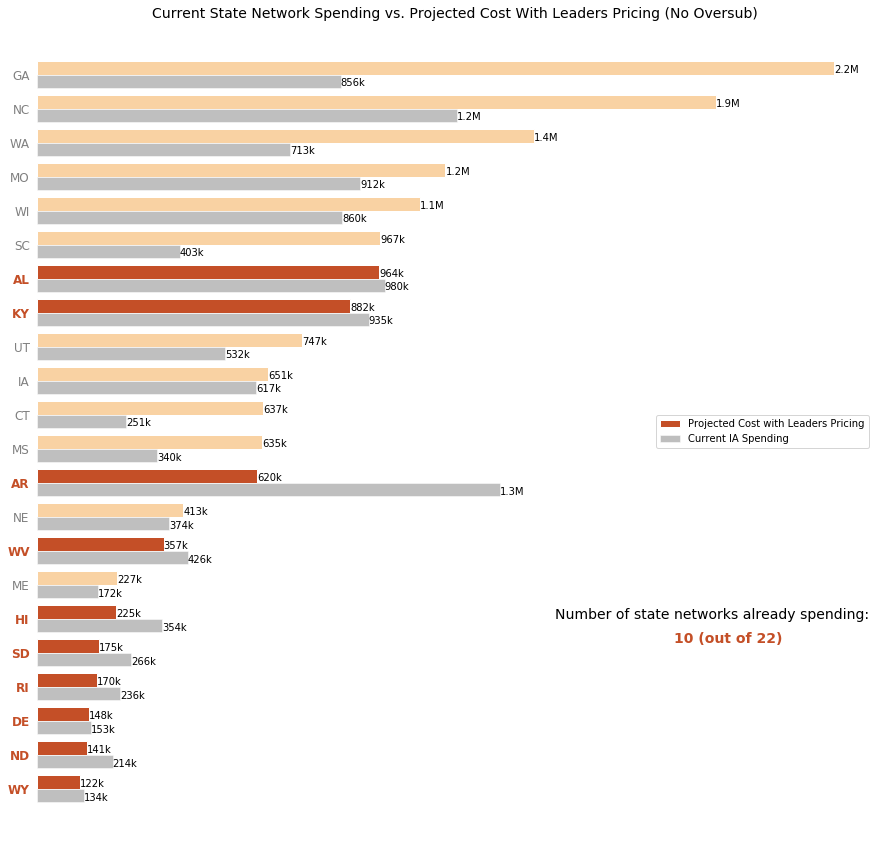

In [39]:
# inputs
sort_col = 'cost_leader_pricing_no_oversub'
compare_col = 'ia_monthly_cost_total'
already_spending_col = 'already_spending_no_oversub'
df_input = df_results.sort_values(sort_col)

# customize colors
colors = []
for proj_cost, orig_cost in zip(df_input[sort_col], df_input[compare_col]): # keys are the names of the boys
    if orig_cost >= proj_cost:
        colors.append('#c44f27')
    else:
        colors.append('#f9d2a3')

fig, ax = plt.subplots(figsize=(15, 15))

bar_size = 0.4

y_locs = np.arange(df_results.shape[0])

rects1 = ax.barh(y_locs, df_input[sort_col], align='edge', edgecolor='white', height=bar_size, color=colors, label="Projected Cost with Leaders Pricing")
rects2 = ax.barh(y_locs - bar_size, df_input[compare_col], edgecolor='white', align='edge', height=bar_size, color='grey', label="Current IA Spending", alpha=0.5)

# pretty plot
plt.yticks(y_locs, df_input.index);
plt.yticks(y_locs, df_input.index);
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), colors):
    ticklabel.set_color('grey')
    ticklabel.set_fontsize(12) 
    if tickcolor == '#c44f27':
        ticklabel.set_color(tickcolor)
        ticklabel.set_fontweight('bold')

plt.title("Current State Network Spending vs. Projected Cost With Leaders Pricing (No Oversub)", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
plt.box(None)
plt.legend(loc='center right');

# add labels
for y0, y1, v0, v1, label_proj, label_sn in zip(y_locs, y_locs - bar_size, 
                                            df_input[sort_col], df_input[compare_col],  
                                                df_input[sort_col+'_pp'], df_input[compare_col+'_pp']):
    plt.text(v0, y0, label_proj, ha='left', va='bottom')
    plt.text(v1, y1, label_sn, ha='left', va='bottom')
    

# add conclusion
plt.text(0.65*max(df_input[sort_col]), 5, 
         'Number of state networks already spending: ', fontsize=14);

plt.text(0.8*max(df_input[sort_col]), 4.3, 
         str(df_input[already_spending_col].sum()) \
         + " (out of " + str(df_input.shape[0]) + ")", fontsize=14, fontweight='bold', color='#c44f27');



In [40]:
# convert notebook to .py 
#!jupyter nbconvert --to script state_networks_projections_1G_10G_leaders_pricing.ipynb

[NbConvertApp] Converting notebook state_networks_projections_1G_10G_leaders_pricing.ipynb to script
[NbConvertApp] Writing 14975 bytes to state_networks_projections_1G_10G_leaders_pricing.py


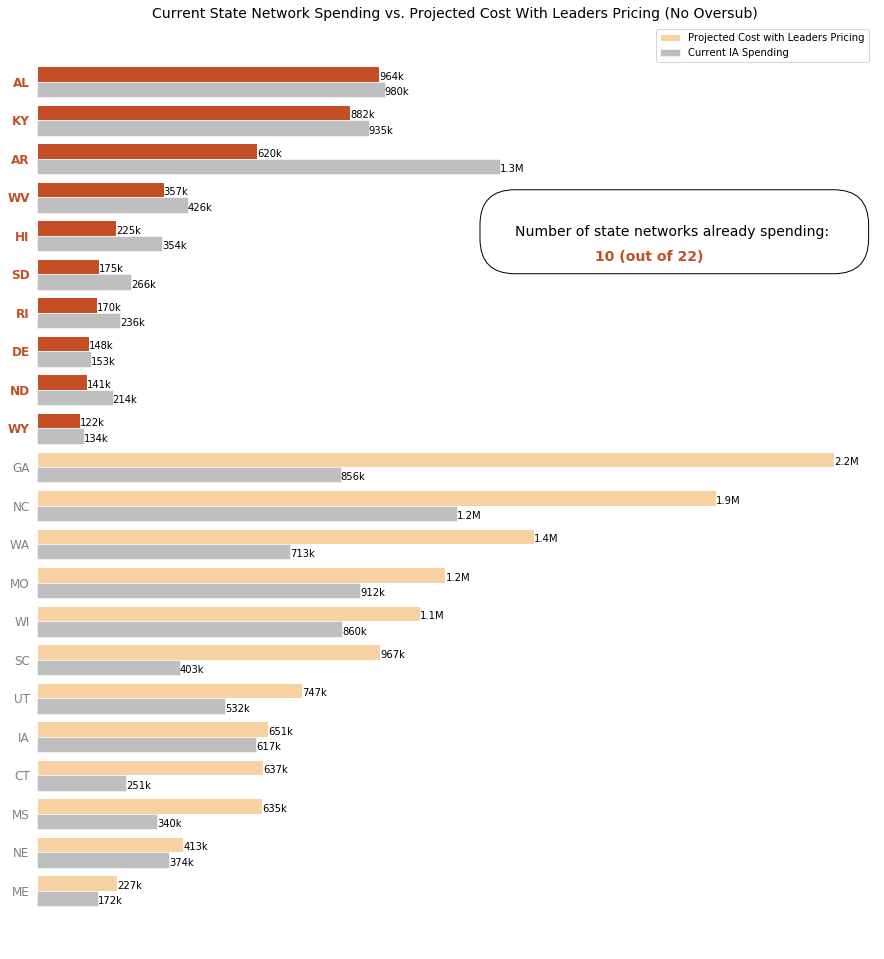

In [57]:
# inputs
sort_col = 'cost_leader_pricing_no_oversub'
compare_col = 'ia_monthly_cost_total'
already_spending_col = 'already_spending_no_oversub'
df_input = df_results.sort_values(['already_spending_no_oversub', sort_col])

# customize colors
colors = []
for proj_cost, orig_cost in zip(df_input[sort_col], df_input[compare_col]): # keys are the names of the boys
    if orig_cost >= proj_cost:
        colors.append('#c44f27')
    else:
        colors.append('#f9d2a3')

fig, ax = plt.subplots(figsize=(15, 17))

bar_size = 0.4

y_locs = np.arange(df_results.shape[0])

rects1 = ax.barh(y_locs, df_input[sort_col], align='edge', edgecolor='white', height=bar_size, color=colors, label="Projected Cost with Leaders Pricing")
rects2 = ax.barh(y_locs - bar_size, df_input[compare_col], edgecolor='white', align='edge', height=bar_size, color='grey', label="Current IA Spending", alpha=0.5)

# pretty plot
plt.yticks(y_locs, df_input.index);
plt.yticks(y_locs, df_input.index);
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), colors):
    ticklabel.set_color('grey')
    ticklabel.set_fontsize(12) 
    if tickcolor == '#c44f27':
        ticklabel.set_color(tickcolor)
        ticklabel.set_fontweight('bold')

plt.title("Current State Network Spending vs. Projected Cost With Leaders Pricing (No Oversub)", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
plt.box(None)
plt.legend(loc='upper right');

# add labels
for y0, y1, v0, v1, label_proj, label_sn in zip(y_locs, y_locs - bar_size, 
                                            df_input[sort_col], df_input[compare_col],  
                                                df_input[sort_col+'_pp'], df_input[compare_col+'_pp']):
    plt.text(v0, y0, label_proj, ha='left', va='bottom')
    plt.text(v1, y1, label_sn, ha='left', va='bottom')
    

# add conclusion
plt.text(0.6*max(df_input[sort_col]), 17, 
         'Number of state networks already spending: ', fontsize=14,  
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=2.5'));

plt.text(0.7*max(df_input[sort_col]), 16.35, 
         str(df_input[already_spending_col].sum()) \
         + " (out of " + str(df_input.shape[0]) + ")", fontsize=14, fontweight='bold', color='#c44f27');